# NicheCompass Single Sample Tutorial

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 17.05.2023
- **Date of Last Modification:** 26.06.2023

In this tutorial, we apply NicheCompass to a single sample (sagittal brain section) of the STARmap PLUS mouse central nervous system dataset / atlas from [Shi, H. et al. Spatial Atlas of the Mouse Central Nervous System at Molecular Resolution. bioRxiv 2022.06.20.496914 (2022)](https://www.biorxiv.org/content/10.1101/2022.06.20.496914v1).

The sample has:
- 91,246 observations at cellular resolution with cell type annotations
- 1022 probed genes

- Check the repository [README.md](https://github.com/sebastianbirk/nichecompass#installation) for NicheCompass installation instructions.
- The data for this tutorial can be downloaded from [OneDrive](https://1drv.ms/f/s!Atya0VClQocLgvRFj0hYrFICVi0C2w?e=2uLfVX). It has to be stored under ```<repository_root>/data/spatial_omics/```.
  - starmap_plus_mouse_cns_batch1.h5ad
- A pretrained model to run only the analysis can be downloaded from [OneDrive](https://1drv.ms/f/s!Atya0VClQocLgvRFj0hYrFICVi0C2w?e=2uLfVX). It has to be stored under ```<repository_root>/artifacts/single_sample/<timestamp>/model/```.
  - xxx

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import squidpy as sq
from matplotlib import gridspec

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                aggregate_obsp_matrix_per_cell_type,
                                create_cell_type_chord_plot_from_df,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                generate_enriched_gp_info_plots,
                                get_unique_genes_from_gp_dict)

### 1.2 Define Parameters

In [36]:
### Dataset ###
dataset = "seqfish_mouse_organogenesis_imputed"
species = "mouse"
spatial_key = "spatial"
n_neighbors = 12
filter_genes = True
n_hvg = 4000

### Model ###
# AnnData Keys
counts_key = "counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
active_gp_thresh_ratio = 0.
node_label_method = "one-hop-norm" # one-hop-attention

# Trainer
n_epochs = 100
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 0. # increase if gene selection desired
l1_targets_categories = ["target_gene"] # targets categories to which l1 regularization will be applied
l1_sources_categories = ["enzyme"] # sources categories to which l1 regularization will be applied
edge_batch_size = 1024 # reduce if not enough memory
use_cuda_if_available = True

### Analysis ###
cell_type_key = "celltype_mapped_refined"
latent_leiden_resolution = 0.2
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "batch"
spot_size = 0.2
agg_weights_key = "agg_weights"
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

### 1.3 Run Notebook Setup

In [37]:
warnings.filterwarnings("ignore")

In [38]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths

In [39]:
# Define paths
ga_data_folder_path = "../data/gene_annotations"
gp_data_folder_path = "../data/gene_programs"
so_data_folder_path = "../data/spatial_omics"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"../artifacts"
model_folder_path = f"{artifacts_folder_path}/single_sample/{current_timestamp}/model"

## 2. Model Preparation

### 2.1 Create Prior Knowledge Cell-Cell-Interaction (CCI) Gene Program (GP) Mask

- NicheCompass expects a prior CCI GP mask as input, which it will use to make its latent embedding interpretable (through a linear masked decoder). 
- The user can provide a custom GP mask to NicheCompass based on the dataset, application, and hypothesis of interest.
- As a default, we create a GP mask based on three databases of prior CCI knowledge:
    - OmniPath
    - NicheNet
    - MEBOCOST

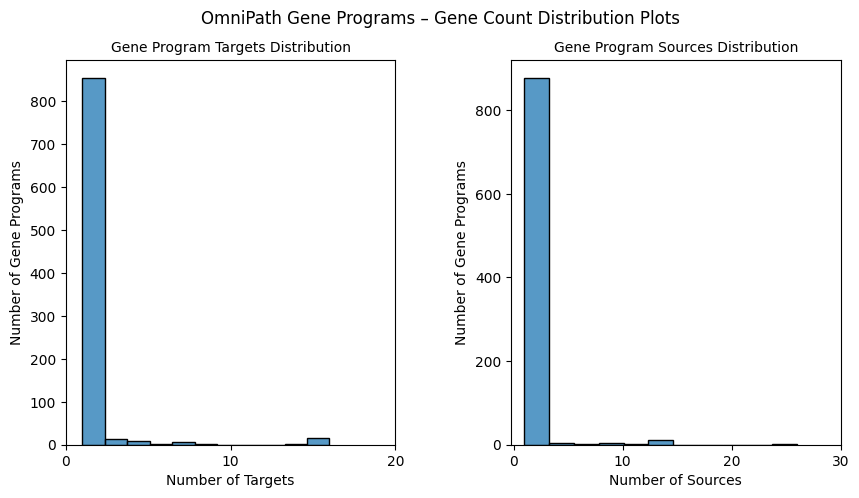

In [40]:
# Retrieve OmniPath GPs (source: ligand gene; target: receptor gene)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    min_curation_effort=0,
    load_from_disk=True,
    save_to_disk=True,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source and target genes from OmniPath GPs to keep
# those genes when filtering
omnipath_genes = get_unique_genes_from_gp_dict(
    gp_dict=omnipath_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

In [41]:
# Display example OmniPath GPs
for i, (key, value) in enumerate(omnipath_gp_dict.items()):
    if i > 2:
        break
    print(key, value)

BDNF_ligand_receptor_GP {'sources': ['Bdnf'], 'targets': ['Drd4'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}
EPOR_ligand_receptor_GP {'sources': ['Epor'], 'targets': ['Stat3'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}
FYN_ligand_receptor_GP {'sources': ['Fyn'], 'targets': ['Mapk7'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}


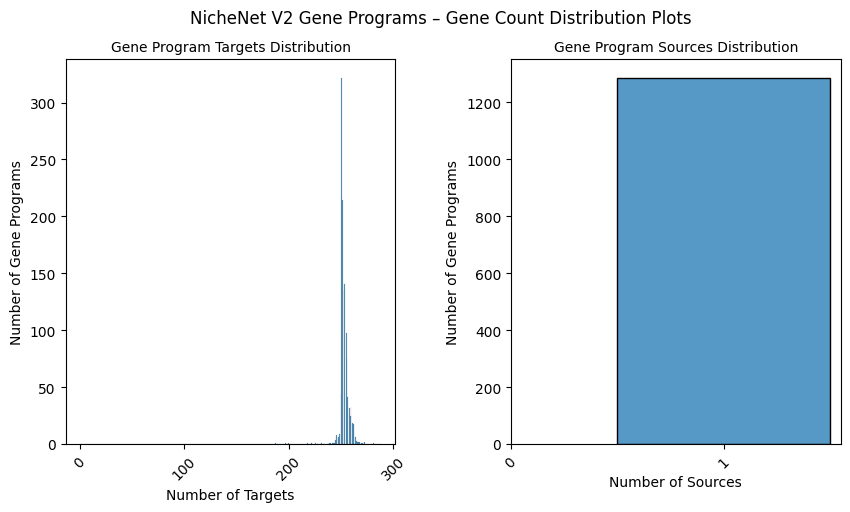

In [42]:
# Retrieve NicheNet GPs (source: ligand gene; target: target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source genes from NicheNet GPs to keep
# those genes when filtering
nichenet_source_genes = get_unique_genes_from_gp_dict(
    gp_dict=nichenet_gp_dict,
    retrieved_gene_entities=["sources"])

In [43]:
# Display example NicheNet GPs
for i, (key, value) in enumerate(nichenet_gp_dict.items()):
    if i > 2:
        break
    print(key, value)

2300002M23Rik_ligand_receptor_target_gene_GP {'sources': ['2300002M23Rik'], 'targets': ['Ddr1', 'Adm', 'Agt', 'Angptl4', 'Ankrd1', 'App', 'Ar', 'Ass1', 'Atf3', 'Bax', 'Bcl2', 'Bcl2l1', 'Bcl2l11', 'Bcl3', 'Bcl6', 'Bdnf', 'Bhlhe40', 'Bin1', 'Birc3', 'Birc5', 'Bmp4', 'Bnip3l', 'Bnip3l-ps', 'Brca1', 'Btg2', 'Cav1', 'Cbx5', 'Ccl12', 'Ccl20', 'Ccl5', 'Ccn1', 'Ccn2', 'Ccna2', 'Ccnb1', 'Ccnb1-ps', 'Ccnd1', 'Ccnd2', 'Cd5l', 'Cdc6', 'Cdca7', 'Cdh1', 'Cdk1', 'Cdk4', 'Cdk6', 'Cdkn1a', 'Cdkn1b', 'Cdkn2a', 'Cdkn2c', 'Cebpa', 'Cflar', 'Cited2', 'Csf2', 'Cxcr4', 'Cyp1a1', 'Cyp1b1', 'Cyp24a1', 'Cyp3a13', 'Ddit3', 'Ddit4', 'Dhrs3', 'Dkk1', 'Dtl', 'Dusp1', 'Dusp6', 'E2f1', 'E2f3', 'Edn1', 'Egfr', 'Egr1', 'Egr2', 'Enc1', 'Eno1', 'Eno1b', 'Epha2', 'Esr1', 'Etfb', 'Fas', 'Fasn', 'Fkbp5', 'Fn1', 'Fos', 'Fosl1', 'Foxo3', 'Fst', 'Gadd45a', 'Gadd45b', 'Gadd45g', 'Gapdh', 'Gapdh-ps15', 'Gata3', 'Gdf15', 'Gm10358', 'Gm3839', 'Gm40460', 'Gm4559', 'Gm45618', 'H2bc14', 'H3f3b', 'H4c12', 'H4c14', 'Hes1', 'Hmga1', 'Hm

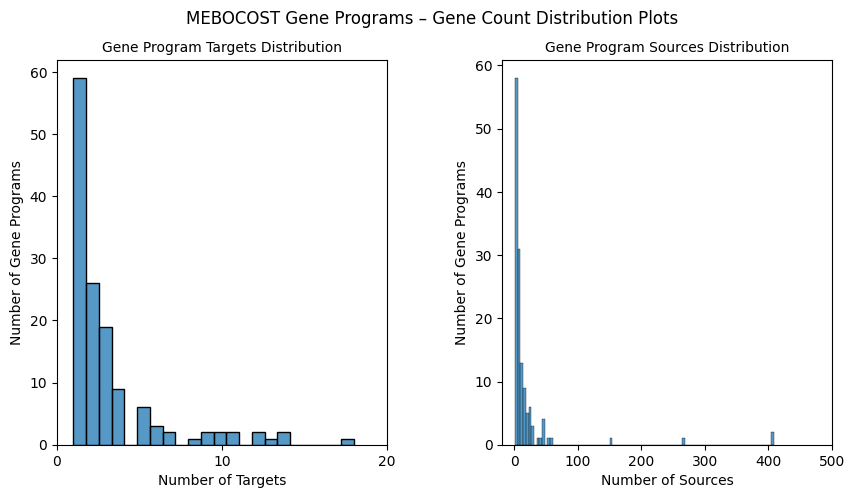

In [44]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source and target genes from MEBOCOST GPs to keep
# those genes when filtering
mebocost_genes = get_unique_genes_from_gp_dict(
    gp_dict=mebocost_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

In [45]:
# Display example MEBOCOST GPs
for i, (key, value) in enumerate(mebocost_gp_dict.items()):
    if i > 2:
        break
    print(key, value)

Deoxyuridine_metabolite_enzyme_sensor_GP {'sources': ['Cda', 'Pnp', 'Pnp2', 'Tk1', 'Tk2', 'Tymp'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme'], 'targets': ['Slc29a2'], 'targets_categories': ['sensor']}
Deoxycytidine_metabolite_enzyme_sensor_GP {'sources': ['Cda', 'Dck', 'Nt5c', 'Nt5c1a', 'Nt5c1b', 'Nt5c2', 'Nt5e', 'Nt5m'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme'], 'targets': ['Slc29a2'], 'targets_categories': ['sensor']}
3-Methoxytyramine_metabolite_enzyme_sensor_GP {'sources': ['Comt', 'Maoa', 'Maob'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme'], 'targets': ['Taar1'], 'targets_categories': ['sensor']}


In [46]:
# Add GPs into one combined dictionary
# for model training
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [47]:
# Filter and combine GPs to avoid overlaps
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Number of gene programs before filtering and combining: 2324.
Number of gene programs after filtering and combining: 1818.


### 2.2 Load Data & Compute Spatial Neighbor Graph

- NicheCompass expects a precomputed spatial adjacency matrix stored in 'adata.obsp[adj_key]'.
- The user can customize the spatial neighbor graph construction based on the dataset, application, and hypothesis of interest.

In [182]:
# Read data
adata = sc.read_h5ad(
        f"{so_data_folder_path}/{dataset}_batch2.h5ad")

In [190]:
"Ccl22" in adata.var_names.tolist()

True

In [191]:
    gp_relevant_genes = list(set(omnipath_genes + 
                                 nichenet_source_genes + 
                                 mebocost_genes))

In [193]:
"Ccl22" in gp_relevant_genes

True

In [187]:
gp_dict_genes = get_unique_genes_from_gp_dict(
    gp_dict=combined_new_gp_dict,
        retrieved_gene_entities=["sources", "targets"])

In [189]:
sc.pp.filter_genes(adata,
                   min_cells=0)
print(f"Keeping {len(adata.var_names)} genes after filtering genes with "
      "expression in 0 cells.")

Keeping 29239 genes after filtering genes with expression in 0 cells.


In [186]:
# Compute spatial neighborhood
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)

# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

### 2.3 Filter Genes

In [212]:
"CCL25" in adata.var.index.str.upper()

True

In [205]:
    gp_dict_genes = get_unique_genes_from_gp_dict(
        gp_dict=combined_new_gp_dict,
            retrieved_gene_entities=["sources", "targets"])

In [207]:
if filter_genes:
    print("\nFiltering genes...")
    # Filter genes and only keep ligand, receptor, metabolite enzyme, 
    # metabolite sensor and the 'n_hvg' highly variable genes (potential target
    # genes of nichenet)
    gp_dict_genes = get_unique_genes_from_gp_dict(
        gp_dict=combined_new_gp_dict,
            retrieved_gene_entities=["sources", "targets"])
    print(f"Starting with {len(adata.var_names)} genes.")
    sc.pp.filter_genes(adata,
                       min_cells=0)
    print(f"Keeping {len(adata.var_names)} genes after filtering genes with "
          "expression in 0 cells.")

    sc.pp.highly_variable_genes(
        adata,
        layer=counts_key,
        n_top_genes=n_hvg,
        flavor="seurat_v3",
        subset=False)

    # Get gene program relevant genes
    gp_relevant_genes = [gene.upper() for gene in list(set(
        omnipath_genes + nichenet_source_genes + mebocost_genes))]
    
    adata.var["gp_relevant"] = (
        adata.var.index.str.upper().isin(gp_relevant_genes))
    adata.var["keep_gene"] = (adata.var["gp_relevant"] | 
                              adata.var["highly_variable"])
    adata = adata[:, adata.var["keep_gene"] == True]
    print(f"Keeping {len(adata.var_names)} highly variable or gene program "
          "relevant genes.")
    adata = (adata[:, adata.var_names[adata.var_names.str.upper().isin(
                [gene.upper() for gene in gp_dict_genes])].sort_values()])
    print(f"Keeping {len(adata.var_names)} genes after filtering genes not in "
          "gp dict.")


Filtering genes...
Starting with 29239 genes.
Keeping 29239 genes after filtering genes with expression in 0 cells.
Keeping 6441 highly variable or gene program relevant genes.
Keeping 5163 genes after filtering genes not in gp dict.


### 2.4 Add GP Mask to Data

In [53]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

In [54]:
import numpy as np

In [60]:
np.mean(adata.varm["nichecompass_gp_sources"].sum(axis=0))

0.6076276664511958

In [61]:
np.mean(adata.varm["nichecompass_gp_targets"].sum(axis=0))

66.57789269553976

### 2.5 Explore Data

In [62]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key=cell_type_key)

Number of nodes (observations): 7656
Number of node features (genes): 2757


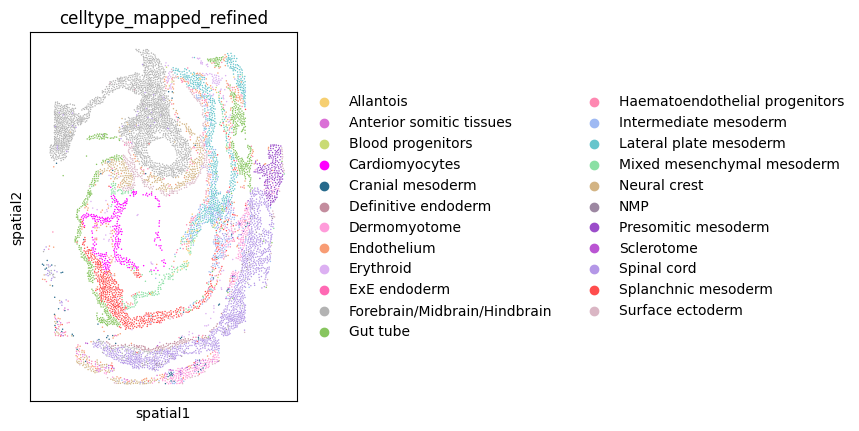

In [66]:
print(f"Number of nodes (observations): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sc.pl.spatial(adata,
              color=cell_type_key,
              palette=cell_type_colors,
              spot_size=0.03)        

## 3. Model Training

In [71]:
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 0.
edge_batch_size = 2048

In [ ]:
del(model)
import gc
gc.collect()
import torch
torch.cuda.empty_cache()

### 3.1 Initialize, Train & Save Model

In [70]:
# Initialize model
model = NicheCompass(adata,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                     latent_key=latent_key,
                     active_gp_thresh_ratio=active_gp_thresh_ratio,
                     node_label_method=node_label_method)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.0
LOG VARIATIONAL -> True
ONE HOP GCN NORM NODE LABEL AGGREGATOR
ENCODER -> n_input: 2757, n_cat_covariates_embed_input: 0, n_layers: 1, n_hidden: 1557, n_latent: 1547, n_addon_latent: 10, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 1547, n_addon_gp_input: 10, n_cat_covariates_embed_input: 0, n_output: 2757
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 1547, n_addon_gp_input: 10, n_cat_covariates_embed_input: 0, n_output: 2757


In [72]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            l1_targets_categories=l1_targets_categories,
            l1_sources_categories=l1_sources_categories,
            edge_batch_size=edge_batch_size,
            use_cuda_if_available=use_cuda_if_available,
            verbose=True)


--- INITIALIZING TRAINER ---
Number of training nodes: 6890
Number of validation nodes: 766
Number of training edges: 46764
Number of validation edges: 5196
Edge batch size: 2048
Node batch size: None

--- MODEL TRAINING ---
Epoch 1/100 |--------------------| 1.0% val_auroc_score: 0.9587; val_auprc_score: 0.9606; val_best_acc_score: 0.5000; val_best_f1_score: 0.6667; train_kl_reg_loss: 43108.8174; train_edge_recon_loss: 370851.9185; train_gene_expr_recon_loss: 3018856.4891; train_masked_gp_l1_reg_loss: 0.0000; train_group_lasso_reg_loss: 0.0000; train_addon_gp_l1_reg_loss: 0.0000; train_global_loss: 3432817.2174; train_optim_loss: 3432817.2174; val_kl_reg_loss: 73945.8047; val_edge_recon_loss: 406611.1562; val_gene_expr_recon_loss: 2564495.0000; val_masked_gp_l1_reg_loss: 0.0000; val_group_lasso_reg_loss: 0.0000; val_addon_gp_l1_reg_loss: 0.0000; val_global_loss: 3045052.0000; val_optim_loss: 3045052.0000
Epoch 2/100 |--------------------| 2.0% val_auroc_score: 0.9503; val_auprc_score

In [102]:
np.array((model.model.get_gp_weights()[0][:2757] > 0).sum(axis=0)[:1547].detach().cpu())

array([0, 0, 0, ..., 1, 0, 0])

In [171]:
model.get_gp_summary()[300:400]

,gp_name,all_gp_idx,gp_active,active_gp_idx,n_source_genes,n_non_zero_source_genes,n_target_genes,n_non_zero_target_genes,gp_source_genes,gp_target_genes,gp_source_genes_weights_sign_corrected,gp_target_genes_weights_sign_corrected,gp_source_genes_importances,gp_target_genes_importances
300,Ccl21b_ligand_receptor_target_gene_GP,300,True,300,0,0,85,85,[],"[Ccl25, H2-K1, Jag1, Spp1, Stc1, Stc2, Igf1, H...",[],"[0.3255, 0.0485, 0.0435, 0.0369, 0.0343, 0.034...",[],"[0.277, 0.0412, 0.037, 0.0314, 0.0292, 0.029, ..."
301,Ccl21d_ligand_receptor_target_gene_GP,301,True,301,0,0,83,83,[],"[Ccl25, C3, Elf3, Erbb3, Cav1, H2-Q2, Nedd9, A...",[],"[0.4017, 0.0513, 0.0478, 0.047, 0.0426, 0.038,...",[],"[0.2902, 0.0371, 0.0345, 0.0339, 0.0308, 0.027..."
302,Ccl22_ligand_receptor_target_gene_GP,302,True,302,0,0,82,82,[],"[Ackr1, Igf1, Gata4, Eif2ak2, Epha2, H2-Q6, Cd...",[],"[0.1406, 0.0577, 0.0575, 0.0476, 0.0372, 0.034...",[],"[0.134, 0.055, 0.0548, 0.0453, 0.0354, 0.0329,..."
303,Ccl24_ligand_receptor_target_gene_GP,303,True,303,0,0,81,81,[],"[Zfp36, Klf5, Tnc, Plec, Gata4, Cav1, H2-Q1, H...",[],"[0.0544, 0.0421, 0.0366, 0.0323, 0.0321, 0.031...",[],"[0.0719, 0.0556, 0.0484, 0.0427, 0.0424, 0.040..."
304,Ccl25_ligand_receptor_target_gene_GP,304,True,304,1,1,79,79,[Ccl25],"[Nars, Ccl6, Sod1, Vcam1, Eya1, Cited2, Snai2,...",[0.6691],"[-0.8446, 0.5266, -0.0388, 0.0383, 0.0372, -0....",[0.2154],"[0.2719, 0.1695, 0.0125, 0.0123, 0.012, 0.0119..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,Cfap54_ligand_receptor_target_gene_GP,395,True,395,0,0,76,76,[],"[Cited4, Armc10, Vps25, Lyrm1, Ell2, Nfe2, Nca...",[],"[0.509, -0.5032, 0.446, 0.3973, 0.3586, 0.322,...",[],"[0.0548, 0.0541, 0.048, 0.0427, 0.0386, 0.0346..."
396,Cfc1_ligand_receptor_target_gene_GP,396,True,396,0,0,76,76,[],"[Mrps33, Ppp1r12b, Suco, Dusp26, Ncoa7, Spink1...",[],"[-0.6615, 0.5226, 0.395, 0.3855, 0.3689, 0.342...",[],"[0.0892, 0.0705, 0.0533, 0.052, 0.0497, 0.0462..."
397,Cfd_ligand_receptor_target_gene_GP,397,True,397,0,0,97,96,[],"[Hoxa9, Wnt5a, Fbn2, Krt15, Sema6a, Hoxc6, Efn...",[],"[0.3501, 0.1796, -0.103, -0.0914, 0.0728, 0.06...",[],"[0.17, 0.0872, 0.05, 0.0444, 0.0353, 0.0327, 0..."
398,Cfh_ligand_receptor_target_gene_GP,398,True,398,0,0,88,87,[],"[Abcg2, Cd55, Tgm2, Ddit3, Prss23, Col18a1, Fr...",[],"[0.1741, 0.1402, -0.0723, 0.0669, 0.0494, -0.0...",[],"[0.0974, 0.0784, 0.0404, 0.0374, 0.0276, 0.025..."


In [177]:
"Ccl25" in model.adata.var_names.tolist()

True

In [213]:
gp = "Ccl25_ligand_receptor_target_gene_GP"
combined_new_gp_dict[gp]
source_gene = combined_new_gp_dict[gp]["sources"][0].lower().capitalize()
target_gene = combined_new_gp_dict[gp]["targets"][0].lower().capitalize()

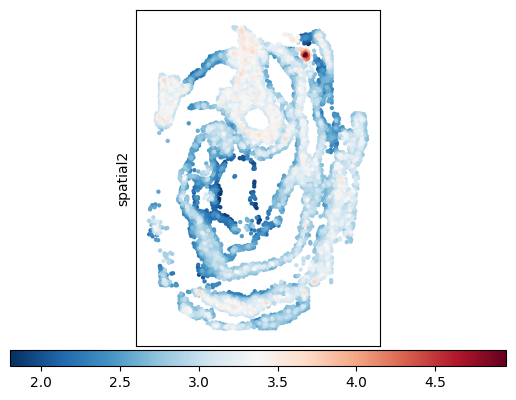

In [215]:
sc.pl.spatial(
    adata=model.adata,
    color=gp,
    color_map="RdBu_r",
    spot_size=0.1,
    title=f"",
    legend_loc=None,
    colorbar_loc="bottom",
    show=True) 

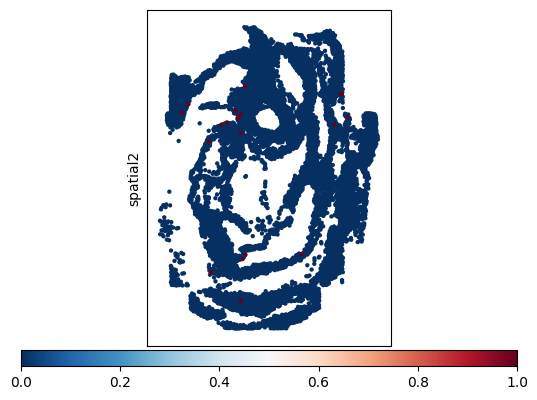

In [216]:
sc.pl.spatial(
    adata=model.adata,
    color=source_gene,
    color_map="RdBu_r",
    spot_size=0.1,
    title=f"",
    legend_loc=None,
    colorbar_loc="bottom",
    show=True) 

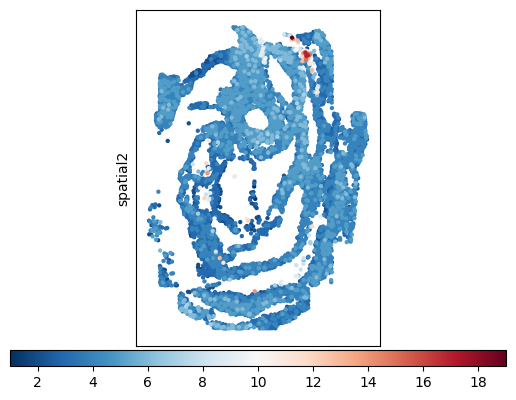

In [218]:
sc.pl.spatial(
    adata=model.adata,
    color="Nars",
    color_map="RdBu_r",
    spot_size=0.1,
    title=f"",
    legend_loc=None,
    colorbar_loc="bottom",
    show=True) 

In [108]:
model.adata.obs

,Area,celltype_mapped_refined,sample,batch,EPOR_ligand_receptor_GP,TP53_ligand_receptor_GP,PTPN6_ligand_receptor_GP,NPPA_ligand_receptor_GP,PTH_ligand_receptor_GP,CCL4_ligand_receptor_GP,...,Add-on 0 GP,Add-on 1 GP,Add-on 2 GP,Add-on 3 GP,Add-on 4 GP,Add-on 5 GP,Add-on 6 GP,Add-on 7 GP,Add-on 8 GP,Add-on 9 GP
embryo1_Pos0_cell10_z5,2256,Lateral plate mesoderm,embryo1,embryo1_z5,1.415099,4.310325,2.682425,3.030813,1.675255,1.928790,...,5.947336,-3.096531,-3.512997,4.317494,7.134125,-4.668744,6.228864,-6.391781,2.364385,0.646096
embryo1_Pos0_cell100_z5,6592,Lateral plate mesoderm,embryo1,embryo1_z5,-2.198321,3.778587,2.953008,4.664229,0.747585,-0.271174,...,5.502828,-3.332077,-3.548229,3.936133,6.497760,-4.137687,5.762893,-5.928879,2.207695,0.207593
embryo1_Pos0_cell101_z5,5952,Allantois,embryo1,embryo1_z5,-0.822952,3.289660,-0.709873,4.931080,4.658414,1.705032,...,4.268584,-2.503382,-4.917289,3.126292,6.830788,-3.871120,5.503682,-5.663566,2.871869,-0.550834
embryo1_Pos0_cell102_z5,11968,Endothelium,embryo1,embryo1_z5,-0.478320,3.453132,6.000906,0.256643,5.132179,1.398183,...,4.270072,-0.698914,-3.557796,3.197799,6.985898,-3.860776,6.285309,-5.503948,2.653329,-1.809630
embryo1_Pos0_cell103_z5,7584,Lateral plate mesoderm,embryo1,embryo1_z5,-2.277138,3.251153,-0.298299,3.966203,5.739064,2.616509,...,4.409785,-2.719248,-4.757715,3.184566,6.721769,-3.836377,5.475315,-5.618238,2.922058,-0.605648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
embryo1_Pos28_cell95_z5,6704,Neural crest,embryo1,embryo1_z5,1.672040,4.389235,-20.516750,-2.428998,-5.717718,3.308650,...,5.321081,-3.116227,-2.091967,4.155582,6.308916,-4.072980,6.150671,-6.741821,1.316529,0.545836
embryo1_Pos28_cell96_z5,4704,Neural crest,embryo1,embryo1_z5,1.674183,4.522476,-22.891420,-3.179953,-6.457706,4.164725,...,5.238744,-2.999887,-2.679317,4.187617,6.475261,-3.955754,6.274940,-6.809009,1.369839,0.414399
embryo1_Pos28_cell97_z5,3408,Endothelium,embryo1,embryo1_z5,2.010400,5.110147,-22.267218,-3.240222,-5.558672,4.824142,...,6.023636,-3.602292,-2.558950,4.742445,7.314928,-4.673241,7.113910,-7.752741,1.618156,0.662515
embryo1_Pos28_cell98_z5,11376,Haematoendothelial progenitors,embryo1,embryo1_z5,1.991046,5.089884,-21.321327,-3.492295,-4.628230,5.409279,...,5.712268,-3.426433,-3.160547,4.565439,7.422446,-4.497331,7.134309,-7.727817,1.829113,0.495998


In [77]:
adata

AnnData object with n_obs × n_vars = 7656 × 2757
    obs: 'Area', 'celltype_mapped_refined', 'sample', 'batch'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'gp_relevant', 'keep_gene'
    uns: 'X_name', 'spatial_neighbors', 'hvg', 'nichecompass_sources_categories_label_encoder', 'nichecompass_targets_categories_label_encoder', 'nichecompass_source_genes_idx', 'nichecompass_target_genes_idx', 'nichecompass_genes_idx', 'nichecompass_gp_names', 'celltype_mapped_refined_colors', 'nichecompass_active_gp_names'
    obsm: 'spatial', 'nichecompass_latent'
    varm: 'nichecompass_gp_sources', 'nichecompass_gp_targets', 'nichecompass_gp_sources_categories', 'nichecompass_gp_targets_categories'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [29]:
len(model.model.get_active_gp_mask())

1433

In [30]:
model.get_active_gps()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1423 but corresponding boolean dimension is 1433

In [ ]:
modality = "rna"
model.model.features_idx_dict_[f"masked_{modality}_idx"]

In [ ]:
gp_weights = model.model.get_gp_weights(only_masked_features=True)

In [ ]:
gp_weights[0].shape

In [ ]:
model.model

In [ ]:
model.model.target_rna_decoder

In [ ]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [ ]:
# Save trained model
model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

## 4. Analysis

In [ ]:
load_timestamp = "26062023_120911"

figure_folder_path = f"{artifacts_folder_path}/single_sample/{load_timestamp}/figures"
model_folder_path = f"{artifacts_folder_path}/single_sample/{load_timestamp}/model"

os.makedirs(figure_folder_path, exist_ok=True)

In [ ]:
# Load trained model
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name="adata.h5ad",
                          gp_names_key=gp_names_key)

In [ ]:
samples = model.adata.obs[sample_key].unique().tolist()

### 4.1 Visualize NicheCompass Embeddings

Let's look at the preservation of cell type annotations in the embedding space. Note that the goal of NicheCompass is not a perfect separation of cell types but rather to identify spatial cellular niches. Nevertheless, it can be useful to look at the cell type annotations if available.

In [ ]:
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=cell_type_key)

In [ ]:
# Create plot of cell type annotations in physical and latent space
groups = None
save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Cell Types " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           groups=groups,palette=cell_type_colors,
           title=f"Cell Types in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[cell_type_key],
                  groups=groups,
                  palette=cell_type_colors,
                  spot_size=spot_size,
                  title=f"Cell Types in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 4.2 Identify Niches

We compute Leiden clustering based on the NicheCompass embeddings to identify spatial cellular niches.

In [ ]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [ ]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

In [ ]:
# Create plot of latent cluster / niche annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["0"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "latent_clusters_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Latent Clusters " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           palette=latent_cluster_colors,
           title=f"Latent Clusters in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[latent_cluster_key],
                  groups=groups,
                  palette=latent_cluster_colors,
                  spot_size=spot_size,
                  title=f"Latent Clusters in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 4.3 Analyze Niches

Now we will analyze the identified spatial cellular niches.

#### 4.3.1 Niche Composition

We can analyze the niche composition in terms of cell type labels.

In [ ]:
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_composition.svg"

df_counts = (model.adata.obs.groupby([latent_cluster_key, cell_type_key])
             .size().unstack())
df_counts.plot(kind="bar", stacked=True, figsize=(10,10))
legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={'size': 10})
legend.set_title("Cell Type Annotations", prop={'size': 10})
plt.title("Cell Type Composition of Niches")
plt.xlabel("Niche")
plt.ylabel("Cell Type Counts")
if save_fig:
    plt.savefig(file_path,
                bbox_extra_artists=(legend,),
                bbox_inches="tight")

#### 4.3.2 Cell Type Neighbor Importances

Now we will investigate neighbor importances in terms of cell type labels of different niches.

In [ ]:
# Retrieve node neighbor importances 
# (aggregation weights of the node label aggregator)
model.adata.obsp[agg_weights_key] = model.get_neighbor_importances()

In [ ]:
# Get cell type neighbor importances for each niche / latent cluster
niche_neighbor_importances_df = aggregate_obsp_matrix_per_cell_type(
    adata=model.adata,
    obsp_key=agg_weights_key,
    cell_type_key=cell_type_key,
    group_key=latent_cluster_key,
    agg_rows=True)

In [ ]:
display(niche_neighbor_importances_df)

In [ ]:
# Generate chord plots showing cell type neighbor importances
# for each niche / latent cluster
groups = "all"
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_neighbor_importances.png"

create_cell_type_chord_plot_from_df(
        adata=model.adata,
        df=niche_neighbor_importances_df,
        link_threshold=0.01,
        cell_type_key=cell_type_key,
        group_key=latent_cluster_key,
        groups=groups,
        plot_label="Niche",
        save_fig=save_fig,
        file_path=file_path)

### 4.4 Perform Differential Gene Program Testing

Now we can test which communication gene programs are differentially expressed in a niche. To this end, we will perform differential gene program testing of a selected niche, e.g. latent cluster / niche "0" (```selected_cats = ["0"]```) vs all other latent clusters / niches (```comparison_cats = "rest"```). However, differential gene program testing can also be performed in the following ways:
- Set ```selected_cats = None``` to perform differential gene program testing across all niches, as opposed to just for one specific niche.
- Set ```comparison_cats = ["2", "3"]``` to perform differential gene program testing against latent clusters / niches "2" and "3" as opposed to against all other latent clusters / niches.

We choose a log bayes factor threshold of 4.6 to determine decisively enriched gene programs. Alternatively, the threshold could be loosened to a value of 2.3 to also allow "only" strongly enriched gene programs to be identified (see https://en.wikipedia.org/wiki/Bayes_factor).

In [ ]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

In [ ]:
# Display example active GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

In [ ]:
# Set parameters for differential gp testing
selected_cats = ["0"]
comparison_cats = "rest"
title = f"NicheCompass Latent Cluster Strongly Enriched Gene Programs"
log_bayes_factor_thresh = 4.6 # 2.3
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_latent_clusters_enriched_gps_dotplot.svg"

In [ ]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [ ]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

In [ ]:
# Create dotplot of results
fig = sc.pl.dotplot(model.adata,
                    enriched_gps,
                    groupby=latent_cluster_key,
                    dendrogram=True, 
                    title=title,
                    swap_axes=True,
                    return_fig=True,
                    figsize=(model.adata.obs[latent_cluster_key].nunique() / 2,
                             len(enriched_gps) / 2))
if save_fig:
    fig.savefig(file_path)
else:
    fig.show()

In [ ]:
# Store gene program summary of enriched gene programs
save_file = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "latent_clusters_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_weights_sign_corrected",
                   "gp_target_genes_weights_sign_corrected",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]

enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

### 4.5 Analyze Enriched Gene Programs

Now we will have a look at the gene program scores as well as the (log normalized) count distributions of
the most important omics features of the differentially expressed gene programs.

In [ ]:
plot_label = f"log_bayes_factor_{log_bayes_factor_thresh}_cluster_0_vs_rest"
save_figs = True

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=latent_cluster_key,
    cat_palette=latent_cluster_colors,
    n_top_enriched_gps=10,
    feature_spaces=samples, # ["latent"]
    n_top_genes_per_gp=3,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)